In [3]:

import numpy as np
import matplotlib.pyplot as plt 
import scipy

import sys
sys.path.append("/home/calab912/Documents/fdm-hybrid-scheme/")

import src.fd as fd 
import src.config as config
import src.animation as animation 
import demonstration.spectral_derivative as sd 

In [4]:
# Generate analytical solution for the 1D free Schrödinger equation
# Li test 1
def generate1DGaussian(x0, x, t, m = 1, hbar = 1, alpha=1.0 / 10):
    psi = np.sqrt(1 / (alpha + 1.0j * t * hbar/m)) * np.exp(
        -((x - x0) ** 2) / (2 * (alpha + 1.0j * t * hbar/m))
    )
    return psi

def periodic1DGaussian(x, dx, t, m = 1, hbar = 1,  x0=5, alpha= 1/20, eps=0, L=10, N=100):
    psi = eps + 0j
    N = 40
    for i in range(-N, N + 1):
        psi += generate1DGaussian(x0, x + L * i, t, m, hbar, alpha)
    return psi 

class Scheme:
    def __init__(self, config, generateIC):

        #print(f"Constructing {self.getName()} scheme")

        self.config              = config
        self.generateIC          = generateIC

        # Set up time management
        self.t0                  = config["t0"]
        self.t                   = config["t0"]
        self.dt                  = config["dt"]
        self.tEnd                = config["tEnd"]
        self.useAdaptiveTimestep = config["useAdaptiveTimestep"]
        self.outputTimestep      = config["outputTimestep"]
        self.timeOrder           = config["timeOrder"]
        self.cfl                 = config["cfl"]
        self.ntmax               = config["maximumNumberOfTimesteps"]



        # Set up grid (evenly-spaced with or without ghost boundary)
        self.dimension           = config["dimension"]
        self.stencilOrder        = config["stencilOrder"] 

        #Since we use np.roll for finite differences there is no need for a ghost boundary with periodic boundary conditions
        self.usePeriodicBC     = config["usePeriodicBC"]
        self.ghostBoundarySize = config["boundarySize"]

        self.useBC = config["useBC"]

        # Set up simulation grid
        N                = config["resolution"]
        self.L0, self.L1 = config["domainSize"]
        self.boxWidth  = self.L1 - self.L0 # physical box width

        self.innerN    = N
        self.dx        = self.boxWidth / (N - 1)

        #Handle ghost boundary
        self.totalN    = self.innerN + 2 * self.ghostBoundarySize
        N              = self.totalN
        Ll             = self.L0 - self.dx * self.ghostBoundarySize
        Lh             = self.L1 + self.dx * self.ghostBoundarySize
        self.PLMWidth  = Lh - Ll # PLM box width

        #Position of lower and upper grid boundary
        self.Ll = Ll 
        self.Lh = Lh 
        

        self.boundaryColumns = np.concatenate([np.arange(self.ghostBoundarySize), \
                                            np.arange(self.innerN + self.ghostBoundarySize, self.innerN + 2 * self.ghostBoundarySize)])
        self.innerColumns    = np.arange(self.ghostBoundarySize, self.innerN + self.ghostBoundarySize)


        self.boundary = np.ix_(self.boundaryColumns)
        self.inner    = np.ix_(self.innerColumns)

        #Create 1D grid
        xlin, self.dx = sd.computeX(self.Ll, self.Lh, self.totalN)
        self.grid = [xlin]

        self.debug = config["debug"]       
        self.hbar  = config["hbar"]
        self.m     = config["m"]
        self.eta   = self.hbar / self.m
        

        # Set up global parameters and constants
        self.G            = config["gravity"]
        self.useCosmology = config["useCosmology"]
        self.useHybrid    = False


        self.C_potential       = config["C_potential"]
        self.C_parabolic       = config["C_parabolic"]



        self.dt            = self.getTimeStep()
        
        self.psi           = self.generateIC(*self.grid, self.dx, self.t          , self.m, self.hbar)
        self.potential     = np.zeros(self.psi.shape)
        self.fields        = self.psi

        #Initialise buffer for fields at t - dt for leapfrog method
        self.old_fields    = self.generateIC(*self.grid, self.dx, self.t - self.dt, self.m, self.hbar)


    def getGrid(self):
        return self.grid

    def getTime(self):
        return self.t

    def getTimeStep(self): 
        if self.useAdaptiveTimestep:
            return self.getAdaptiveTimeStep()
        else:
            return self.dt 

    def getAdaptiveTimeStep(self):
        raise NotImplementedError("Please Implement this method")

    def getConfig(self):
        return self.config

    def getUpdatedFields(self, dt, fields):
        raise NotImplementedError("Please Implement this method")

    def setBoundaryConditions(self, fields):
        raise NotImplementedError("Please Implement this method")

    def getScaleFactor(self):
        return 1

    def run(self, tfin = None, enableBackward = False):
        if tfin is None:
            tfin = self.tEnd
        i = 0
        while(self.t < tfin - 1e-15):
            dt = self.getTimeStep()

            if (tfin - self.t < dt):
                dt = tfin - self.t

            self.step(dt)
            i += 1
            if i > self.ntmax:
                print("Maximum number of timesteps reached. Aborting.")
                break
        
        if enableBackward:
            while(tfin < self.t):
                dt = self.getTimeStep()

                if (self.t - tfin < dt):
                    dt = self.t - tfin

                self.step(-dt)
                i += 1
                if i > self.ntmax:
                    print("Maximum number of timesteps reached. Aborting.")
                    break
        print(f"Finished in {i} time steps")


    #Dummy function for implementation of first kick in kick-drift-kick scheme
    def kick1(self, fields, dt):
        return fields

    #Dummy function for implementation of second kick in kick-drift-kick scheme
    #Here the gravitational potential should be updated
    def kick2(self, fields, dt):
        return fields

    def getName(self):
        raise NotImplementedError("Please Implement this method")

    def getPotential(self):
        return self.potential

    def getScaleFactor(self):
        if self.useCosmology:
            return 1
        else:
            return 1

    def getPsi(self):
        return self.psi 

    def setPsi(self, psi):
        self.psi = psi 
        if self.G != 0:
            self.potential = self.computePotential(np.abs(self.psi)**2)

    def getDensity(self):
        return np.abs(self.psi) ** 2

    def getPhase(self):
        return fd.make_continuous(np.angle(self.psi))
        
    def getAdaptiveTimeStep(self):
        t1 = self.C_parabolic * self.dx**2/self.eta
        if self.G > 0:
            t2 = self.C_potential    * self.hbar/np.max(np.abs(self.potential) + 1e-8)
        else:
            t2 = 1e4
        
        return np.min([t1, t2])

    def setBoundaryConditions(self, psi, t):
        f = self.generateIC(*self.grid, self.dx, t, self.m, self.hbar)
        psi[self.boundary] = f[self.boundary]
        
    def computeRelErrorArray(self):
        psi_ref = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        return np.abs(np.abs(self.psi[self.inner])**2 - np.abs(psi_ref[self.inner])**2) / (np.abs(psi_ref[self.inner])**2)
    
    def computeAbsErrorArray(self):
        psi_ref = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        return np.abs(np.abs(self.psi[self.inner])**2 - np.abs(psi_ref[self.inner])**2)
    
    def computeRelError(self):
        psi_ref = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        l_infty_diff = np.max(np.abs(np.abs(self.psi[self.inner])**2 - np.abs(psi_ref[self.inner])**2))
        l_infty_ref  = np.max(np.abs(psi_ref)**2)
        return l_infty_diff/l_infty_ref 


    def computeRMSError(self):
        psi_ref = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        d1 = np.abs(self.psi[self.inner])**2
        d2 = np.abs(psi_ref[self.inner])**2
        RMS = np.sqrt(np.sum((d1 - d2)**2))
        RMS /= len(d1)
        return RMS
    

class GramExtensionScheme(Scheme): 
    def __init__(self, config, generateIC):
        super().__init__(config, generateIC)
        self.Gamma  = 150
        self.g      = 63
        self.nDelta = 8
        self.nd     = 28

        Gamma, g, nD, nd = self.Gamma, self.g, self.nDelta, self.nd 

        self.F = np.fromfile(f"/home/calab912/Documents/fdm-hybrid-scheme/demonstration/nD={nD}_nd={nd}_g={g}_Gamma={Gamma}.bin").reshape(nD * 2, 2 * nD + 2 * nd - 4) 
        self.Pl = np.fromfile(f"/home/calab912/Documents/fdm-hybrid-scheme/demonstration/Pleft_nD={nD}.bin").reshape( nD, nD)
        self.Pr = np.fromfile(f"/home/calab912/Documents/fdm-hybrid-scheme/demonstration/Pright_nD={nD}.bin").reshape(nD, nD)
        self.Fe = self.F[:nD, :]
        self.Fo = self.F[nD:, :]

        print(self.Pl)
        print(self.Pr)
        print(self.Fe)
        print(self.Fo)
        self.proj   = config.get("projectionOrder", 8)
        self.psi    = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)
        self.fields = self.psi
        self.counter = 0
        self.alpha   = config.get("alpha", 0) 
        self.p       = config.get("p", 1) 

    def step(self, dt):
        if self.useBC:
            self.setBoundaryConditions(self.psi, self.t)

        Coeff1 = 1j * 20#1/2  * dt * self.eta
        x      = self.grid[0]
        nDelta = self.nDelta 

        self.psi = np.arange(28)**1  + 1j * np.arange(28)**1

        f  = self.psi
        fl = self.psi[:nDelta]
        fr = self.psi[-nDelta:]

        print(self.psi)

        al     = self.Pl @ fl 
        ar     = self.Pr @ fr 

        print("Al: ", al) 
        print("Ar: ", ar) 
        al[self.proj+1:] = 0
        ar[self.proj+1:] = 0
        fpl    = al @ self.Pl 
        fpr    = ar @ self.Pr
        fmatch = (al + ar)/2 @ self.Fe + (ar - al)/2 @ self.Fo

        fdp = np.concatenate([fpl, f[nDelta:-nDelta], fpr, fmatch[nDelta:nDelta + self.nd]])

        for i in range(len(fdp) - 2):
            print(f"i = {i} psi =  {np.real(fdp[i])} + i {np.imag(fdp[i])}")

        fhat = scipy.fft.fft(fdp[:-2]) 

        for i in range(len(fhat)):
            print(f"i = {i} psik =  {np.real(fhat[i])} + i {np.imag(fhat[i])}")


        k = sd.computeK(fhat, 1, sd.PERIODIC)

        eta = np.abs(k / (np.max(np.abs(k))))
        
        print("Max k: ", np.max(np.abs(k)))
        for i in range(len(eta)):
            print(f"i = {i} filter =  {np.exp(-self.alpha * (eta)**(2*self.p))[i]}")
        for i in range(len(eta)):
            print(f"i = {i} exp =  {np.exp(-Coeff1 * k**2)[i]}")
        

        #plt.plot(eta, np.exp(-self.alpha * (eta)**(2*self.p)))
        #plt.show() 
        fhat = fhat * np.exp(-self.alpha * (eta)**(2*self.p))
        for i in range(len(fhat)):
            print(f"i = {i} filtered psik =  {np.real(fhat[i])} + i {np.imag(fhat[i])}")

        fhat = fhat * np.exp(-Coeff1 * k**2) 
        for i in range(len(fhat)):
            print(f"i = {i} evolved psik =  {np.real(fhat[i])} + i {np.imag(fhat[i])}")

        
        self.psi = scipy.fft.ifft(fhat)[:len(self.psi)]
        for i in range(len(self.psi)):
            print(f"i = {i} transform back psi =  {np.real(self.psi[i])} + i {np.imag(self.psi[i])}")
        self.t += dt
        self.counter += 1 


    def getName(self):
        return "gram fourier extension scheme"
    
    def getDx(self): 
        return self.x[1] - self.x[0]
    


[[ 0.35355339  0.35355339  0.35355339  0.35355339  0.35355339  0.35355339
   0.35355339  0.35355339]
 [-0.54006172 -0.38575837 -0.23145502 -0.07715167  0.07715167  0.23145502
   0.38575837  0.54006172]
 [ 0.54006172  0.07715167 -0.23145502 -0.38575837 -0.38575837 -0.23145502
   0.07715167  0.54006172]
 [-0.43082022  0.30772873  0.43082022  0.18463724 -0.18463724 -0.43082022
  -0.30772873  0.43082022]
 [ 0.28203804 -0.52378493 -0.12087344  0.36262033  0.36262033 -0.12087344
  -0.52378493  0.28203804]
 [-0.14978617  0.49215457 -0.36376642 -0.32097037  0.32097037  0.36376642
  -0.49215457  0.14978617]
 [ 0.06154575 -0.30772873  0.55391171 -0.30772873 -0.30772873  0.55391171
  -0.30772873  0.06154575]
 [-0.01706972  0.11948803 -0.35846409  0.59744015 -0.59744015  0.35846409
  -0.11948803  0.01706972]]
[[ 0.35355339  0.35355339  0.35355339  0.35355339  0.35355339  0.35355339
   0.35355339  0.35355339]
 [-0.54006172 -0.38575837 -0.23145502 -0.07715167  0.07715167  0.23145502
   0.38575837  0

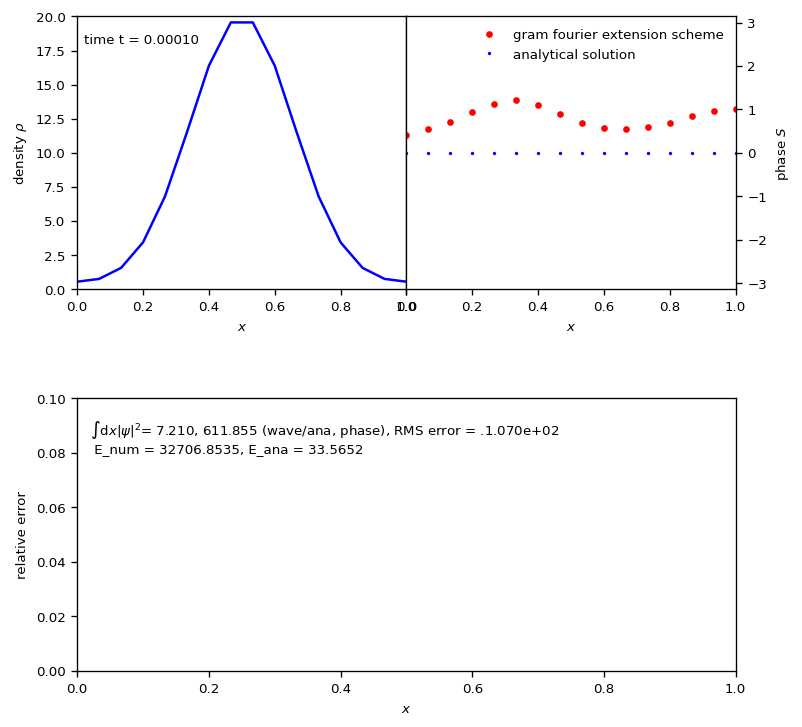

In [5]:

def periodic1DGaussian(x, dx, t, m = 1, hbar = 1,  x0=.5, alpha= 1/20, eps=0, L=1, N=100):
    psi = eps + 0j
    N = 40
    L = 1
    for i in range(-N, N + 1):
        psi += generate1DGaussian(x0, x + L * i, t, m, hbar, alpha)
    return psi 

c = config.generateConfig()
c["t0"]                         = 0.0
c["tEnd"]                       = 1.0
c["resolution"]                 = 16
c["boundarySize"]               = 6
c["useBC"]                      = True
c["domainSize"]                 = [0, 1]
c["xlim"]                       = [0, 1]
c["dpi"]                        = 120
c["densityYlim"]                = [0, 20]
c["useAdaptiveTimestep"]        = True 
c["C_parabolic"]                = 0.4
c["alpha"]                      = 16 * np.log(10)
c["p"]                          = 50
c["projectionOrder"]            = 8
scheme = GramExtensionScheme(c, periodic1DGaussian) 
scheme.step(1e-4)
animation.drawFrame(scheme)

In [ ]:
def printCMatrix(mat, name):
    n, m = mat.shape
    print(f"const real {name}[{n}][{m}] = ", end="")
    print("{")
    for i in range(n):
        print("{", end="")
        for j in range(m):
            print(f"{mat[i,j]:10.64f}", end="")
            if j != m - 1:
                print(", ", end="")
        

        print("}", end=",\n")  
    print("}", end="")  

printCMatrix(scheme.Fe, "Fe")
print("")
printCMatrix(scheme.Fo, "Fo")
print("")
printCMatrix(scheme.Pl, "Pl")
print("")
printCMatrix(scheme.Pr, "Pr")

const real Fe[12][76] = {
{0.2886751345948128655294340205728076398372650146484375000000000000, 0.2886751345948128655294340205728076398372650146484375000000000000, 0.2886751345948128655294340205728076398372650146484375000000000000, 0.2886751345948128655294340205728076398372650146484375000000000000, 0.2886751345948128655294340205728076398372650146484375000000000000, 0.2886751345948128655294340205728076398372650146484375000000000000, 0.2886751345948128655294340205728076398372650146484375000000000000, 0.2886751345948128655294340205728076398372650146484375000000000000, 0.2886751345948128655294340205728076398372650146484375000000000000, 0.2886751345948128655294340205728076398372650146484375000000000000, 0.2886751345948128655294340205728076398372650146484375000000000000, 0.2886751345948128655294340205728076398372650146484375000000000000, 0.2886751345948128655294340205728076398372650146484375000000000000, 0.2886751345948128655294340205728076398372650146484375000000000000, 0.2886751345948128655

In [78]:

class SubregionScheme(Scheme):
    def __init__(self, config, generateIC, scheme):
        super().__init__(config, generateIC)
  
        if "printGrid" in config: 
            self.print_grid = config["printGrid"]
        else:
            self.print_grid = False

        self.patchSize = config["patchSize"]

        # Create sub patches
        self.NPatch = int(self.innerN/self.patchSize)
        self.patchWidth = self.dx * (self.patchSize - 1)

        if self.print_grid: 
            print(f"Domain size = {self.Lh - self.Ll} Patch number = {self.NPatch}, patch size = {self.patchSize} and patch width = {self.patchWidth} and patch number times patch width = {self.patchWidth * self.NPatch}")

        self.patches = []
    
        patchConfig = dict(config)
        patchConfig["resolution"]  = self.patchSize
        patchConfig["useBC"] = False
        for i in range(self.NPatch):
            patchConfig["domainSize"] = [self.L0 + (i) * self.dx * self.patchSize, self.L0 + i * self.dx * self.patchSize + self.patchWidth]
            self.patches.append(scheme(patchConfig, generateIC))
            if self.print_grid:
                print(f"Patch {i}: domainSize: ", patchConfig["domainSize"], " the grid: ", self.patches[i].grid, " dx: ", self.patches[i].dx)

        if self.print_grid:
            print("The master grid: domainSize: ", config["domainSize"], " the grid: ", self.grid, " dx: ", self.dx)

        #Make sure everything agrees on the bit-level
        for i in range(self.NPatch):
            self.patches[i].dx = self.dx 

            i0 =  i      * self.patchSize
            i1 = (i + 1) * self.patchSize + 2 * self.ghostBoundarySize
            if self.print_grid:
                print(f"Filling patch {i} with data from {i0} to {i1 - 1}")
            
            self.patches[i].psi = np.copy(self.psi[ i0 : i1 ])

        self.debugWavefunction = False 
        self.debugShiftfunction = False 


    #def getUpdatedFields(self, t, dt, old_psi):
    def step(self, dt):
        #self.psi = np.copy(old_psi)

        print_grid = self.print_grid
        
        if 0:
            plt.title("Before boundary overwrite")
            plt.plot(self.psi.real)
            plt.plot(self.psi.imag)
            plt.show()

        if 1:
            f = self.generateIC(*self.grid, self.dx, self.t, self.m, self.hbar)

            if print_grid:
                print(f"Writing BC to {self.boundary}")


            #Set outer ghost zone
            self.psi[self.boundary] = f[self.boundary]

        else:
            self.psi[ :self.ghostBoundarySize] = np.roll(self.psi, 2*self.ghostBoundarySize)[:self.ghostBoundarySize]
            self.psi[-self.ghostBoundarySize:] = np.roll(self.psi,-2*self.ghostBoundarySize)[-self.ghostBoundarySize:]

        if 0:
            plt.title("After boundary overwrite")
            plt.plot(self.psi.real)
            plt.plot(self.psi.imag)
            plt.show()

        patchpgb  = self.patchSize + 2 * self.ghostBoundarySize

        #Fill ghost zones of patches and set boundary conditions
        for i in range(self.NPatch):

            i0 =  i      * self.patchSize
            i1 = (i + 1) * self.patchSize + 2 * self.ghostBoundarySize
            if print_grid:
                print(f"Filling patch {i} with data from {i0} to {i1 - 1}")
            
            self.patches[i].psi = np.copy(self.psi[ i0 : i1 ])
            if print_grid:
                print(f"This means the points {self.grid[0][ i0 : i1 ]} that should include the patch's boundary points {self.patches[i].grid[0][self.patches[i].boundary]} ")
            

        #Advance patches 
        for i in range(self.NPatch):
            self.patches[i].debugWavefunction = self.debugWavefunction 
            self.patches[i].debugShiftfunction = self.debugShiftfunction
            self.patches[i].step(dt)

        #Write updated patch data back to global array
        for i in range(self.NPatch):
            i0 = self.ghostBoundarySize + i * self.patchSize
            i1 = self.ghostBoundarySize + (i + 1) * self.patchSize

            if print_grid:
                    print(f"Writing patch {i} inner {self.patches[i].inner[0], self.patches[i].inner[-1] - 1} to [{i0}, {i1 - 1}]")
            self.psi[ i0 : i1 ] = self.patches[i].psi[self.patches[i].inner]
        
        self.t += dt
        #return self.psi# - old_psi



    def getName(self):
        return "subregion scheme"
    

    def getAdaptiveTimeStep(self):
        t1 = self.C_parabolic * self.dx**2/self.eta
        if self.G > 0:
            t2 = self.C_potential    * self.hbar/np.max(np.abs(self.potential) + 1e-8)
        else:
            t2 = 1e4
        t3 = 1e6#self.ghostBoundarySize * 4/np.pi**2  * self.dx**3
        
        return np.min([t1, t2, t3])


Finished in 40323 time steps


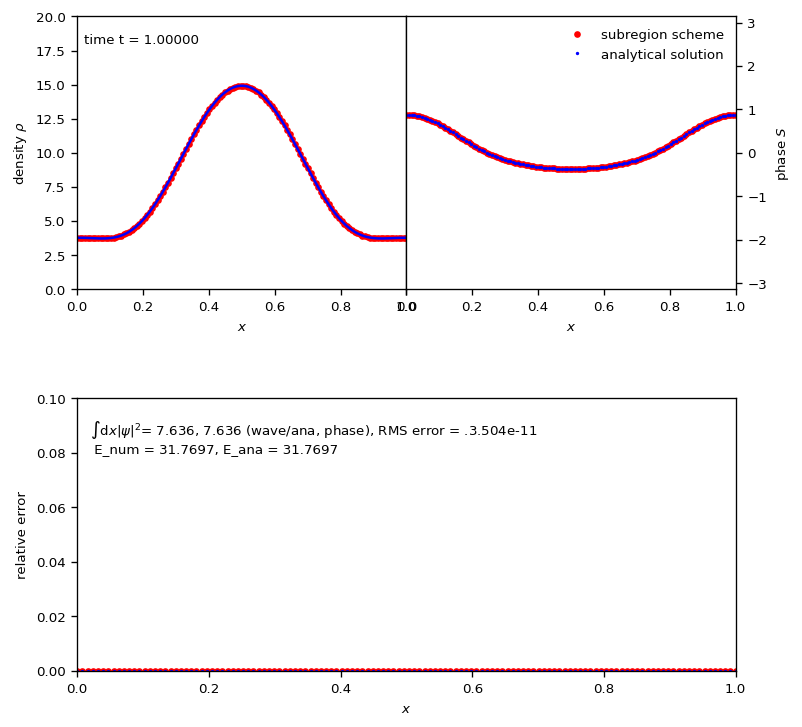

In [187]:

c = config.generateConfig()
c["t0"]                         = 0.0
c["tEnd"]                       = 1.0
c["resolution"]                 = 128
c["patchSize"]                  = 16
c["boundarySize"]               = 6
c["useBC"]                      = True
c["domainSize"]                 = [0, 1]
c["xlim"]                       = [0, 1]
c["dpi"]                        = 120
c["densityYlim"]                = [0, 20]
c["useAdaptiveTimestep"]        = True 
c["C_parabolic"]                = 0.4
c["printGrid"]                  = False
c["alpha"]                      = 12 * np.log(10)
c["p"]                          = 10
c["projectionOrder"]            = 12
scheme = SubregionScheme(c, periodic1DGaussian, GramExtensionScheme) 
scheme.run()
animation.drawFrame(scheme)
